In [32]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Resolução da EDO

$ m\frac{d²x}{dt²} + kx = 0, t_{0} = 0, x(0) = 0, x'(0) = 1$

Onde m = 0,5 kg e k = 200 N/m

Solução exata da EDO:

$ \frac{sin(20t)}{20} $

Nesse arquivo estou usando apenas o fenômeno físico

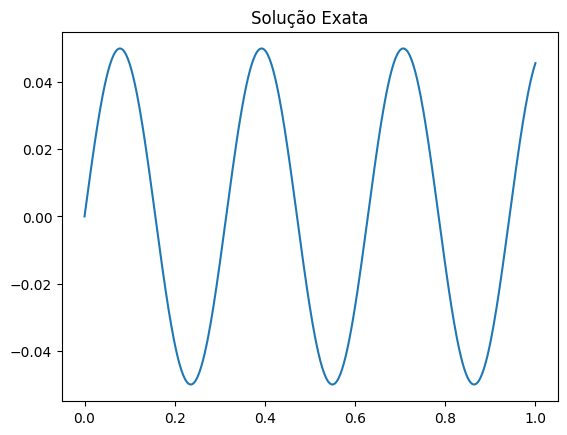

In [33]:
def sExata(t):
    x = np.sin(20*t)/20
    return x

t = np.linspace(0, 1 , 500)
t = tf.cast(t, tf.float32)
t = tf.expand_dims(t, 1)

x = sExata(t)

plt.plot(t, x)
plt.title("Solução Exata")
plt.show()

In [34]:
t_fis = tf.linspace(0, 1 , 500)
t_fis = tf.cast(t_fis, tf.float32)
t_fis = tf.expand_dims(t_fis, 1)

t0 = tf.zeros(t_fis.shape)

tf.random.set_seed(42)
lr = 0.001
epochs = 10000

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = 'tanh', use_bias=True, bias_initializer='ones'),
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(64, activation = 'tanh'),
    tf.keras.layers.Dense(1, activation = 'linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

In [35]:
def fis_loss(y_true, y_pred):
  with tf.GradientTape() as tape:
    # Derivadas para resolver a EDO
    with tf.GradientTape() as divl:
      divl.watch(t_fis)
      with tf.GradientTape() as div2:
        div2.watch(t_fis)
        x_fis = y_pred
        x_fis = model(t_fis)
        xdt = div2.gradient(x_fis, t_fis)
    xdtt = divl.gradient(xdt, t_fis)

    # Cálculo da EDO
    fis = 0.5*xdtt + 200*x_fis

    # Derivada para condições iniciais
    with tf.GradientTape() as init:
      init.watch(t0)
      x0 = model(t0)
      x0dt = init.gradient(x0, t0)

    # Losses
    loss_init_X0 = tf.reduce_mean(tf.square(x0))
    loss_init_X0DT =  tf.reduce_mean(tf.square(x0dt-1))
    fis_l = tf.reduce_mean(tf.square(fis))
    loss = fis_l + (1e5)*(loss_init_X0 + loss_init_X0DT)

    # Backpropagation
    grads = tape.gradient (loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss, fis_l

model.compile(optimizer = optimizer, loss = fis_loss, metrics=[fis_loss])

history = model.fit(t_fis, sExata(t_fis), epochs = epochs, verbose = 0)

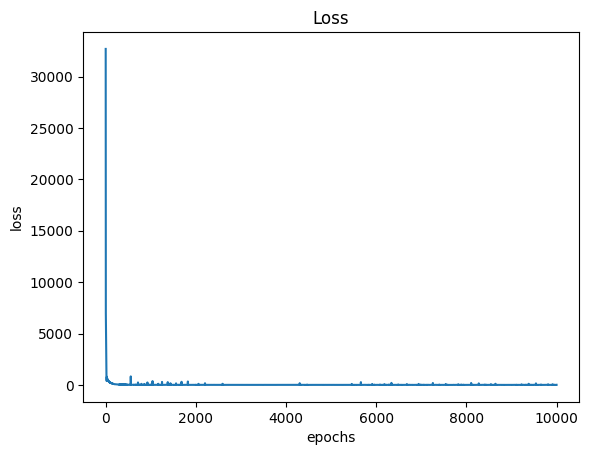

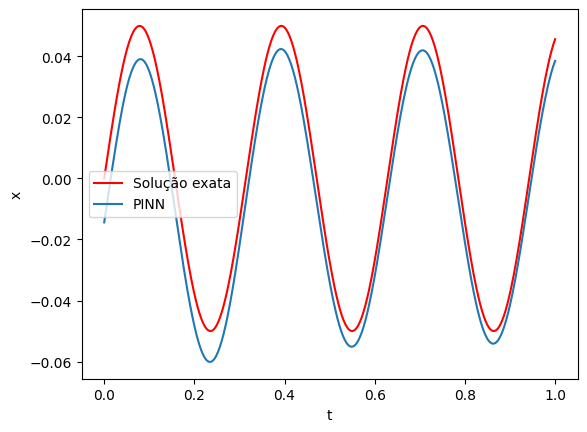

In [36]:
plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'])
plt.xlabel('epochs');plt.ylabel('loss')

plt.figure()
plt.plot(t, x,'r', label="Solução exata")
plt.plot(t_fis,model(t_fis),label="PINN")
plt.xlabel('t');plt.ylabel('x')
plt.legend()